In [1]:
test_mp4, test_depth, test_intr = "./raw_data/rgb_20250711_040525", "./raw_data/depth_20250711_040525", "./raw_data/intrinsics_20250711_040525"

In [2]:
import cv2
from frame_processor import FrameProcessor
from mock_camera import MockCamera

from config import Config 

camera_intrinsics = Config.CAMERA_INTRINSICS
#Config.CAMERA_INTRINSICS

camera = MockCamera(rgb_folder=test_mp4, depth_folder=test_depth, intrinsics_folder=test_intr)
processor = FrameProcessor(camera_intrinsics)
processor.set_tracking_enabled(True)
camera.start()

# Обработка и отображение
while True:
   color, depth, depth_intrinsics= camera.get_frames()
   if color is None or depth is None:
       break
   
   # Обработка кадра
   results = processor.process_frame(color, depth, depth_intrinsics)
   
   # Отображение результата (combined = RGB + Depth + Cleaned)
   cv2.imshow('Processed Video', results['combined'])
   
   # Или только обработанный RGB с масками
   # cv2.imshow('Processed Video', results['color_with_mask'])
   
   if cv2.waitKey(25) & 0xFF == ord('q'):
       break

camera.stop()
cv2.destroyAllWindows()

# Вывод статистики
print(f"Обработано кадров: {processor.frame_count}")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
TOP DIMENSIONS:
0: [     2.2238     0.73349     0.25648]
1: [     2.0016     0.69839     0.24077]
2: [     2.2176     0.73933      0.2533]
3: [     2.0177     0.66926     0.14497]
4: [     2.5017      0.8045     0.40382]
5: [     2.4928     0.73203     0.39565]
Object 0: габариты 2.224x0.733x0.256 м, объем 0.4184 м³, 2505 точек
TOP DIMENSIONS:
0: [    0.52481     0.33743     0.17452]
1: [     1.2042      0.5393     0.31804]
2: [    0.52694     0.35998     0.16513]
3: [    0.50996      0.3456      0.1504]
4: [     0.5175     0.35982     0.16206]
5: [    0.50106     0.34765     0.15727]
Object 1: габариты 0.525x0.337x0.175 м, объем 0.0309 м³, 770 точек
[FILTER] Area change too large: 0.64
TOP DIMENSIONS:
0: [     1.5129       0.608     0.23835]
1: [    0.71942     0.51648      0.1007]
2: [      0.935     0.52416    0.0945

In [3]:
import numpy as np
completed_objects = processor.get_completed_objects()
print(f"\nЗавершено объектов: {len(completed_objects)}")

# Анализ результатов
for idx, obj in enumerate(completed_objects):
    print(f"\n Объект №: {idx}")
    print(f"  Точек в облаке: {len(obj['point_cloud'])}")
    print(f"  Всего масок: {len(obj['all_masks'])}")
    print(f"  Габариты: {obj['dimensions'][0]:.3f}x{obj['dimensions'][1]:.3f}x{obj['dimensions'][2]:.3f} м, ")


Завершено объектов: 9

 Объект №: 0
  Точек в облаке: 2505
  Всего масок: 21
  Габариты: 2.224x0.733x0.256 м, 

 Объект №: 1
  Точек в облаке: 770
  Всего масок: 35
  Габариты: 0.525x0.337x0.175 м, 

 Объект №: 2
  Точек в облаке: 687
  Всего масок: 18
  Габариты: 0.719x0.516x0.101 м, 

 Объект №: 3
  Точек в облаке: 150
  Всего масок: 12
  Габариты: 0.565x0.185x0.058 м, 

 Объект №: 4
  Точек в облаке: 607
  Всего масок: 25
  Габариты: 0.512x0.265x0.172 м, 

 Объект №: 5
  Точек в облаке: 2505
  Всего масок: 21
  Габариты: 2.224x0.733x0.256 м, 

 Объект №: 6
  Точек в облаке: 770
  Всего масок: 35
  Габариты: 0.525x0.337x0.175 м, 

 Объект №: 7
  Точек в облаке: 687
  Всего масок: 18
  Габариты: 0.719x0.516x0.101 м, 

 Объект №: 8
  Точек в облаке: 150
  Всего масок: 12
  Габариты: 0.565x0.185x0.058 м, 


In [4]:
import open3d as o3d
import numpy as np

def visualize_point_cloud_with_bbox(result):
    """Визуализация облака точек с ориентированным bounding box"""
    # Создаем облако точек
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(result['point_cloud'])
    pcd.paint_uniform_color([0.5, 0.5, 0.5])
    
    # Создаем линии для отображения bounding box
    bbox_lines = create_bbox_lines(result['centroid'], result['dimensions'], result['rotation_matrix'])
    
    # Текст с размерами
    print(f"Габариты: {result['dimensions'][0]:.3f} x {result['dimensions'][1]:.3f} x {result['dimensions'][2]:.3f} м")
    print(f"Объем: {result['volume']:.4f} м³")
    print(f"Точек: {result['num_points']}")
    
    # Визуализация
    o3d.visualization.draw_geometries(
        [pcd, bbox_lines],
        window_name="Облако точек с габаритами",
        width=800, height=600
    )

def create_bbox_lines(center, extent, rotation):
    """Создание линий bounding box"""
    # Вершины box в локальных координатах
    corners = np.array([
        [-extent[0]/2, -extent[1]/2, -extent[2]/2],
        [extent[0]/2, -extent[1]/2, -extent[2]/2],
        [extent[0]/2, extent[1]/2, -extent[2]/2],
        [-extent[0]/2, extent[1]/2, -extent[2]/2],
        [-extent[0]/2, -extent[1]/2, extent[2]/2],
        [extent[0]/2, -extent[1]/2, extent[2]/2],
        [extent[0]/2, extent[1]/2, extent[2]/2],
        [-extent[0]/2, extent[1]/2, extent[2]/2]
    ])
    
    # Поворот и смещение
    corners = (rotation @ corners.T).T + center
    
    # Индексы линий
    lines = [[0,1],[1,2],[2,3],[3,0],
             [4,5],[5,6],[6,7],[7,4],
             [0,4],[1,5],[2,6],[3,7]]
    
    # Создание LineSet
    line_set = o3d.geometry.LineSet()
    line_set.points = o3d.utility.Vector3dVector(corners)
    line_set.lines = o3d.utility.Vector2iVector(lines)
    line_set.colors = o3d.utility.Vector3dVector([[1, 0, 0] for _ in lines])
    
    return line_set

In [8]:
visualize_point_cloud_with_bbox(completed_objects[1])

Габариты: 0.525 x 0.337 x 0.175 м
Объем: 0.0309 м³
Точек: 770


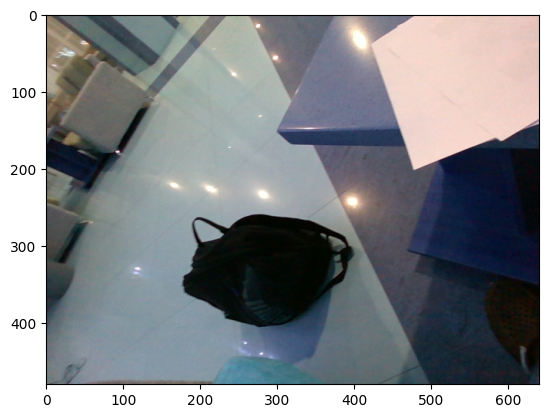

In [7]:
import matplotlib.pyplot as plt
plt.imshow(completed_objects[1]['rgb_image'])